In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 下載 bid 文件
file_id_bid = '1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx'
url_bid = f"https://drive.google.com/uc?export=download&id={file_id_bid}"
output_bid = 'data_bid.csv'
gdown.download(url_bid, output_bid, quiet=False)

# 下載 ask 文件
file_id_ask = '1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c'
url_ask = f"https://drive.google.com/uc?export=download&id={file_id_ask}"
output_ask = 'data_ask.csv'
gdown.download(url_ask, output_ask, quiet=False)

# 讀取下載的文件
data_bid = pd.read_csv('data_bid.csv')
data_ask = pd.read_csv('data_ask.csv')

Downloading...
From: https://drive.google.com/uc?export=download&id=1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx
To: /content/data_bid.csv
100%|██████████| 37.6M/37.6M [00:00<00:00, 212MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c
To: /content/data_ask.csv
100%|██████████| 37.5M/37.5M [00:00<00:00, 232MB/s]


In [ ]:
# 使用左外連接合併，這樣假設bid的數據筆數多，它的數據不會遺失
data = pd.merge(data_bid, data_ask, on='Local time', how='left')

# 使用fillna填充NaN值，你可以使用特定值或其他策略，這裡我用0作為例子
data = data.fillna(0)

# 計算平均價格
data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
data['Average_High'] = (data['High_x'] + data['High_y']) / 2
data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
data['Total_Volume'] = data['Volume_x'] + data['Volume_y']
columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
data = data.drop(columns=columns_to_drop)

In [ ]:
# 計算價格和成交量的變化
data['Price_Change'] = data['Average_Close'].pct_change()
data['Volume_Change'] = data['Total_Volume'].pct_change()
# 創建未來三分鐘的收盤價欄位
data['Future_Close'] = data['Average_Close'].shift(-3)
data['three_minutes_Change'] = data['Future_Close'] - data['Average_Open']
# 處理缺失值和無窮大
data.replace([np.inf, -np.inf], np.nan, inplace=True)

missing_cols = data.columns[data.isnull().any()]
for col in missing_cols:
    data[col].fillna(data[col].median(), inplace=True)
# 嘗試使用完整的格式轉換日期時間
data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.000 GMT+0800', errors='coerce')

# 對於剩下的非NaT項目，再次嘗試使用不帶GMT部分的基本格式轉換
data.loc[data['Local time'].isna(), 'Local time'] = pd.to_datetime(data[data['Local time'].isna()]['Local time'], format='%d.%m.%Y %H:%M:%S')
delete_condition = (
    ((data['Local time'].dt.weekday == 5) & (data['Local time'].dt.hour >= 5)) |
    (data['Local time'].dt.weekday == 6) |
    ((data['Local time'].dt.weekday == 0) & (data['Local time'].dt.hour < 5))
)
late_market_open_condition = (
    (data['Local time'].dt.weekday == 0) &
    (data['Local time'].dt.hour == 5) &
    (data['Local time'].dt.minute < 4) &
    (data['Total_Volume'] == 0)
)

# 組合上述兩個刪除條件
combined_delete_condition = delete_condition | late_market_open_condition
data.drop(data[combined_delete_condition].index, inplace=True)
data.reset_index(drop=True, inplace=True)

#print(data.head(23338))

In [ ]:
# 將價格變動轉換為類別
def label(three_minutes_Change):
    if three_minutes_Change > 0:
        return 2
    elif three_minutes_Change < 0:
        return 0
    else:
        return 1

data['Label'] = data['three_minutes_Change'].apply(label)

# 提取日期時間特徵
data['Local time'] = pd.to_datetime(data['Local time'])
data['Year'] = data['Local time'].dt.year
data['Month'] = data['Local time'].dt.month
data['Day'] = data['Local time'].dt.day
data['DayOfWeek'] = data['Local time'].dt.dayofweek
data['Hour'] = data['Local time'].dt.hour
data['Minute'] = data['Local time'].dt.minute

# 轉換日期時間特徵為循環特徵
data['DayOfWeekSin'] = np.sin((data['DayOfWeek']) * (2. * np.pi / 7))
data['DayOfWeekCos'] = np.cos((data['DayOfWeek']) * (2. * np.pi / 7))
data['HourSin'] = np.sin(data['Hour'] * (2. * np.pi / 24))
data['HourCos'] = np.cos(data['Hour'] * (2. * np.pi / 24))

# 去掉不需要的列
data = data.drop('Local time', axis=1)

# 定義特徵和目標變量
features = [
    "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
    "Year", "Month", "Day", "Hour", "Minute",
    "DayOfWeek", "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
]
label = "Label"

# 按照時間順序分割訓練集、驗證集、和測試集
train_size = round(len(data) * 0.8)
temp_size = len(data) - train_size
val_test_size = round(temp_size * 0.5)

train_data = data.iloc[:train_size].copy()
val_data = data.iloc[train_size:train_size + val_test_size].copy()
test_data = data.iloc[train_size + val_test_size:].copy()

# 計算訓練數據的滑動窗口標準差
window_size = 5
train_data['Std_Dev'] = train_data['Average_Close'].rolling(window_size).std()

# 計算驗證數據的滑動窗口標準差
val_data['Std_Dev'] = val_data['Average_Close'].rolling(window_size).std()

# 計算測試數據的滑動窗口標準差
test_data['Std_Dev'] = test_data['Average_Close'].rolling(window_size).std()

# 補充 features 以包括 'Std_Dev'
features.append('Std_Dev')

x_train = train_data[features]
y_train = train_data[label]
x_val = val_data[features]
y_val = val_data[label]
x_test = test_data[features]
y_test = test_data[label]

x_train = x_train.fillna(x_train.mean())
x_val = x_val.fillna(x_train.mean())
x_test = x_test.fillna(x_train.mean())

# 資料正規化
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# 檢查每個資料集的大小
print("Size of training data:", len(train_data))
print("Size of validation data:", len(val_data))
print("Size of test data:", len(test_data))

# 確定資料按時間順序進行分割
print("\nTraining data time range:", train_data.index.min(), "to", train_data.index.max())
print("Validation data time range:", val_data.index.min(), "to", val_data.index.max())
print("Test data time range:", test_data.index.min(), "to", test_data.index.max())

Size of training data: 300821
Size of validation data: 37602
Size of test data: 37603

Training data time range: 0 to 300820
Validation data time range: 300821 to 338422
Test data time range: 338423 to 376025


In [ ]:
model = GradientBoostingClassifier(random_state=0)

# 設定超參數分佈
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.75, 1],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}


#使用RandomizedSearchCV
rand_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
rand_search.fit(x_train, y_train)

#輸出最佳參數
print("Best Parameters:", rand_search.best_params_)

#使用最佳超參數來建立模型
best_model = rand_search.best_estimator_

#使用驗證集驗證模型
y_val_pred = best_model.predict(x_val)
print('Validation Accuracy: ', accuracy_score(y_val, y_val_pred))
print('Validation Confusion Matrix: \n', confusion_matrix(y_val, y_val_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.75, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.01}
Validation Accuracy:  0.6462954098186267
Validation Confusion Matrix: 
 [[12122     2  6331]
 [  335     2   357]
 [ 6273     2 12178]]


In [ ]:
from sklearn.metrics import classification_report
#使用最佳超參數建立模型
best_model = GradientBoostingClassifier(
    subsample=0.75,
    n_estimators=50,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=7,
    learning_rate=0.01,
    random_state=0
)

best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

Test Accuracy:  0.6464377842193442
Test Confusion Matrix: 
 [[11895     1  6167]
 [  383     2   352]
 [ 6388     4 12411]]


In [ ]:
print('Classification Report for Test Set: \n', classification_report(y_test, y_pred, digits=5))

Classification Report for Test Set: 
               precision    recall  f1-score   support

           0    0.63725   0.65853   0.64772     18063
           1    0.28571   0.00271   0.00538       737
           2    0.65563   0.66005   0.65783     18803

    accuracy                        0.64644     37603
   macro avg    0.52620   0.44043   0.43698     37603
weighted avg    0.63955   0.64644   0.64019     37603



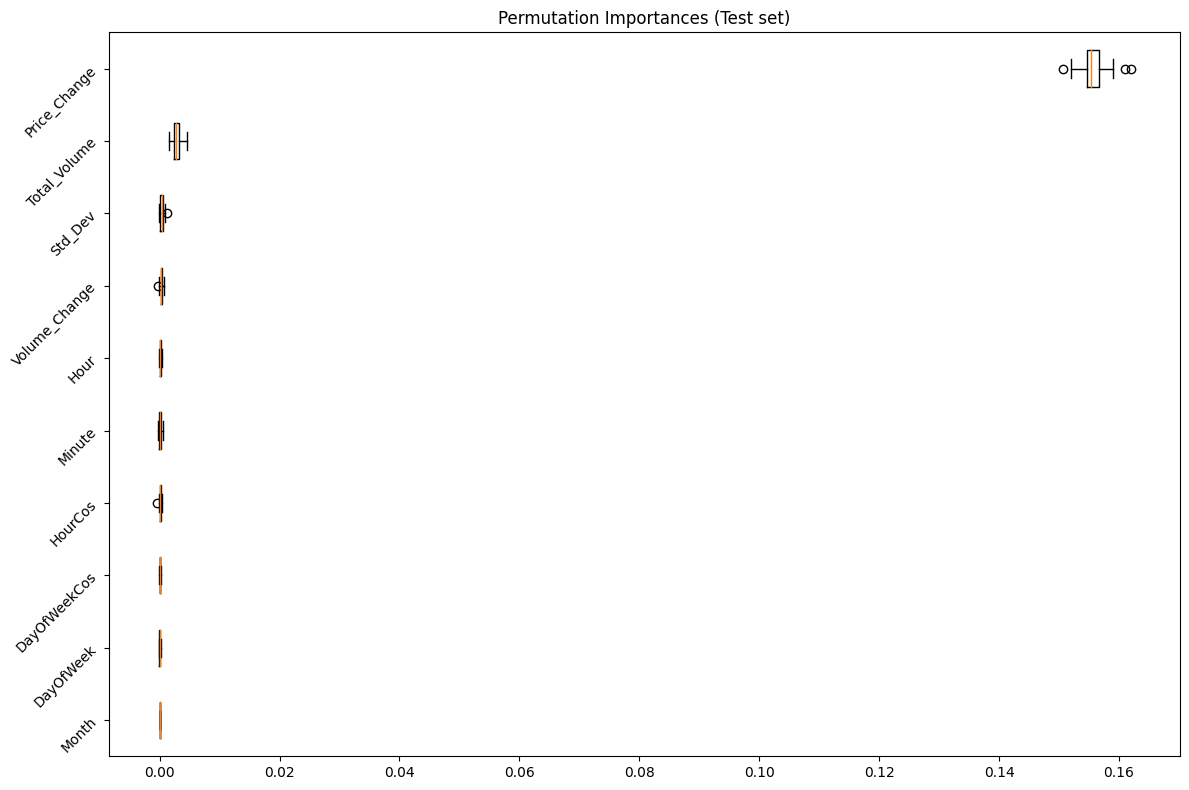

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# 計算 permutation importance
result = permutation_importance(best_model, x_test, y_test, n_repeats=30, random_state=0)

# 獲得特征的排序索引
sorted_idx = result.importances_mean.argsort()[-10:]  # 只選取最重要的前10個特征

# 繪製特征重要性
fig, ax = plt.subplots(figsize=(12, 8))  # 增加圖片尺寸
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(features)[sorted_idx])
ax.set_title("Permutation Importances (Test set)")
ax.tick_params(axis='y', labelsize=10, rotation=45)  # 旋轉標籤並減少字體大小
fig.tight_layout()
plt.show()


In [ ]:
# 根据重要性排序特征
sorted_indices = result.importances_mean.argsort()[::-1]

# 打印特征和其对应的重要性
print("Feature Importance:")
for idx in sorted_indices:
    print(f"{features[idx]:<20} : {result.importances_mean[idx]:.4f} ± {result.importances_std[idx]:.4f}")


Feature Importance:
Price_Change         : 0.1558 ± 0.0024
Total_Volume         : 0.0028 ± 0.0007
Std_Dev              : 0.0004 ± 0.0003
Volume_Change        : 0.0003 ± 0.0002
Hour                 : 0.0001 ± 0.0002
Minute               : 0.0001 ± 0.0002
HourCos              : 0.0001 ± 0.0001
DayOfWeekCos         : 0.0001 ± 0.0001
DayOfWeek            : 0.0000 ± 0.0001
Month                : 0.0000 ± 0.0000
Year                 : 0.0000 ± 0.0000
DayOfWeekSin         : -0.0000 ± 0.0000
Average_Open         : -0.0001 ± 0.0001
Day                  : -0.0002 ± 0.0002
HourSin              : -0.0002 ± 0.0002
Average_Close        : -0.0004 ± 0.0001


In [ ]:
y_pred = best_model.predict(x_test)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))


def calculate_profit(conf_matrix):
    profit = 0

    # 標籤0且預測為0，獲利0.9
    profit += conf_matrix[0, 0] * 0.9

    # 標籤0但預測為2，損失1
    if conf_matrix.shape[1] > 2:
        profit -= conf_matrix[0, 2]

    # 標籤2且預測為2，獲利0.9
    if conf_matrix.shape[0] > 2 and conf_matrix.shape[1] > 2:
        profit += conf_matrix[2, 2] * 0.9

    # 標籤2但預測為0，損失1
    if conf_matrix.shape[0] > 2:
        profit -= conf_matrix[2, 0]

    return profit


profit = calculate_profit(conf_matrix)
print("總獲利：", profit)

Test Accuracy:  0.6464377842193442
Test Confusion Matrix: 
 [[11895     1  6167]
 [  383     2   352]
 [ 6388     4 12411]]
總獲利： 9320.4


In [ ]:
def martingale_strategy(predictions, true_values, verbose=False):
    balance = 0  # 起始餘額為0，代表沒有任何本金
    bet = 1  # 初始投注金額

    for i, (pred, true) in enumerate(zip(predictions, true_values)):
        if pred == true:  # 預測正確，贏得賭注
            balance += 0.9 * bet
            #if verbose:
                #print(f"Trade {i + 1}: WIN  | Bet: ${bet} | Balance: ${round(balance, 1)}")
            bet = 1
        else:  # 預測錯誤，輸掉賭注
            balance -= bet
            #if verbose:
                #print(f"Trade {i + 1}: LOSE | Bet: ${bet} | Balance: ${round(balance, 1)}")
            bet *= 2  # 加倍投注金額

    return round(balance, 1)  # 返回淨利潤


subset_size = 37603
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]

# 使用模型進行預測
y_pred_subset = best_model.predict(x_test_subset)

# 計算馬丁格爾策略淨利潤
print("Martingale Strategy:")
profit_martingale = martingale_strategy(y_pred_subset, y_test_subset, verbose=True)

print("\n總獲利:", profit_martingale)

Martingale Strategy:

總獲利: 18153.6


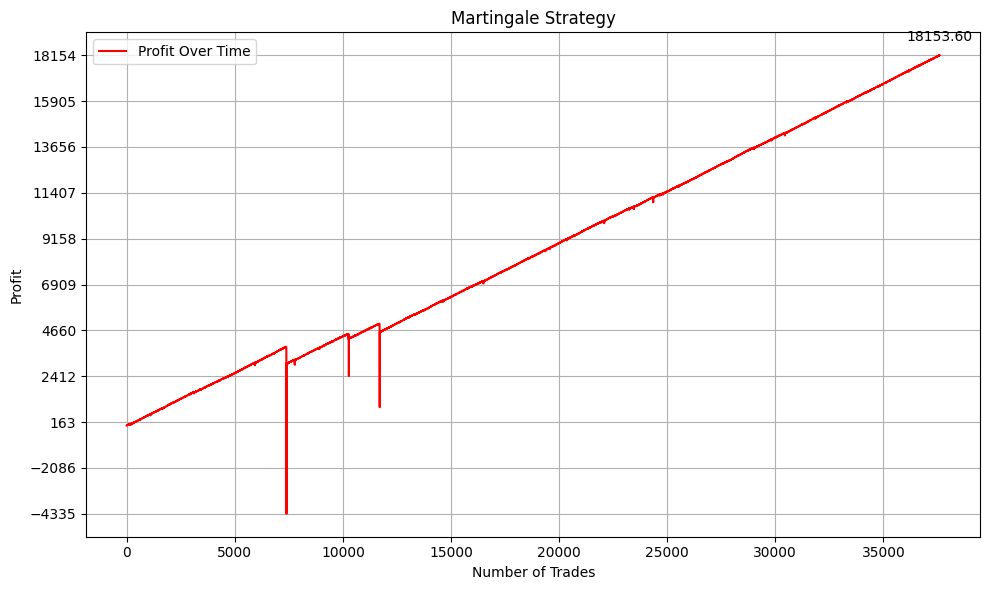

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def martingale_strategy(predictions, true_values):
    balances = []
    balance = 0
    bet = 1

    for i, (pred, true) in enumerate(zip(predictions, true_values)):
        if pred == true:
            balance += 0.9 * bet
            bet = 1
        else:
            balance -= bet
            bet *= 2
        balances.append(balance)

    return balances


predictions = best_model.predict(x_test)
balances = martingale_strategy(predictions, y_test)  # 使用模型的預測結果和真實結果


plt.figure(figsize=(10, 6))
plt.plot(balances, label="Profit Over Time", color="red")
plt.xlabel("Number of Trades")
plt.ylabel("Profit")
plt.title("Martingale Strategy")
plt.grid(True)
plt.legend()
plt.tight_layout()

min_balance = min(balances)
max_balance = max(balances)
yticks_interval = (max_balance - min_balance) / 10
plt.yticks(np.arange(min_balance, max_balance + yticks_interval, yticks_interval))

final_balance = balances[-1]
plt.annotate(f"{final_balance:.2f}", (len(balances)-1, final_balance), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()